[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/time-travel.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239536-lesson-5-time-travel)

# Time travel

## Review

We discussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

We showed how breakpoints can stop the graph at specific nodes or allow the graph to dynamically interrupt itself.

Then we showed how to proceed with human approval or directly edit the graph state with human feedback.

## Goals

Now, let's show how LangGraph [supports debugging](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/) by viewing, re-playing, and even forking from past states. 

We call this `time travel`.

In [2]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [4]:
from dotenv import load_dotenv
load_dotenv('studio/.env')

True

Let's build our agent.

In [5]:
from langchain_anthropic import ChatAnthropic
import math

def multiply(a: float, b: float) -> float:
    """Multiply a and b.

    Args:
        a: first number
        b: second number
    """
    return a * b

def add(a: float, b: float) -> float:
    """Adds a and b.

    Args:
        a: first number
        b: second number
    """
    return a + b

def divide(a: float, b: float) -> float:
    """Divide a by b.

    Args:
        a: first number
        b: second number
    """
    return a / b

def subtract(a: float, b: float) -> float:
    """Subtract b from a.

    Args:
        a: first number
        b: second number
    """
    return a - b

def power(a: float, b: float) -> float:
    """Raise a to the power of b.

    Args:
        a: base number
        b: exponent
    """
    return a ** b

def square_root(a: float) -> float:
    """Calculate the square root of a.

    Args:
        a: number to find square root of
    """
    return math.sqrt(a)

def modulo(a: float, b: float) -> float:
    """Calculate a modulo b (remainder of a divided by b).

    Args:
        a: dividend
        b: divisor
    """
    return a % b

def absolute_value(a: float) -> float:
    """Calculate the absolute value of a.

    Args:
        a: number
    """
    return abs(a)

def factorial(n: int) -> int:
    """Calculate the factorial of n.

    Args:
        n: non-negative integer
    """
    return math.factorial(n)

def logarithm(a: float, base: float = math.e) -> float:
    """Calculate the logarithm of a with given base (default is natural log).

    Args:
        a: number
        base: logarithm base (default is e for natural log)
    """
    return math.log(a, base)

tools = [add, subtract, multiply, divide, power, square_root, modulo, absolute_value, factorial, logarithm]
llm = ChatAnthropic(model="claude-haiku-4-5-20251001")
llm_with_tools = llm.bind_tools(tools)

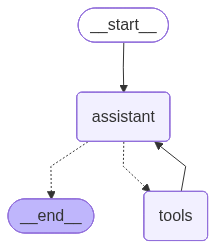

In [6]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Let's run it, as before.

In [7]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================

[{'id': 'toolu_01S3iAz59fERvXBMjdoRSDL8', 'input': {'a': 2, 'b': 3}, 'name': 'multiply', 'type': 'tool_use'}]
Tool Calls:
  multiply (toolu_01S3iAz59fERvXBMjdoRSDL8)
 Call ID: toolu_01S3iAz59fERvXBMjdoRSDL8
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6.0
================================== Ai Message ==================================

The result of multiplying 2 and 3 is **6**.


## Browsing History

We can use `get_state` to look at the **current** state of our graph, given the `thread_id`!

In [8]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='4c4a3581-8055-454e-8132-18b0f4811997'), AIMessage(content=[{'id': 'toolu_01S3iAz59fERvXBMjdoRSDL8', 'input': {'a': 2, 'b': 3}, 'name': 'multiply', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01FkWxncwzDCjvUEFEQ5vg2i', 'model': 'claude-haiku-4-5-20251001', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 1300, 'output_tokens': 69, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-haiku-4-5-20251001'}, id='lc_run--1abaa4d5-b030-4a60-b4c9-75b60615cdbe-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'toolu_01S3iAz59fERvXBMjdoRSDL8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1300, 'output_tokens': 69, 'total_

We can also browse the state history of our agent.

`get_state_history` lets us get the state at all prior steps.


In [9]:
all_states = [s for s in graph.get_state_history(thread)]

In [10]:
len(all_states)

5

The first element is the current state, just as we got from `get_state`.

In [11]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='4c4a3581-8055-454e-8132-18b0f4811997')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b3589-fd38-6e00-8000-c1060b6b0929'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-27T17:16:06.842109+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b3589-fd37-6f3c-bfff-c424a2db4574'}}, tasks=(PregelTask(id='1b520bc8-c672-67b0-6f56-cb7b316de83d', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content=[{'id': 'toolu_01S3iAz59fERvXBMjdoRSDL8', 'input': {'a': 2, 'b': 3}, 'name': 'multiply', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01FkWxncwzDCjvUEFEQ5vg2i', 'model': 'claude-haiku-4-5-20251001', 'stop_reason': 'tool_use', 'stop_seq

Everything above we can visualize here: 

![fig1.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038211b544898570be3_time-travel1.png)

## Replaying 

We can re-run our agent from any of the prior steps.

![fig2.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038a0bd34b541c78fb8_time-travel2.png)

Let's look back at the step that recieved human input!

In [12]:
to_replay = all_states[-2]

In [13]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='4c4a3581-8055-454e-8132-18b0f4811997')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b3589-fd38-6e00-8000-c1060b6b0929'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-27T17:16:06.842109+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b3589-fd37-6f3c-bfff-c424a2db4574'}}, tasks=(PregelTask(id='1b520bc8-c672-67b0-6f56-cb7b316de83d', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content=[{'id': 'toolu_01S3iAz59fERvXBMjdoRSDL8', 'input': {'a': 2, 'b': 3}, 'name': 'multiply', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01FkWxncwzDCjvUEFEQ5vg2i', 'model': 'claude-haiku-4-5-20251001', 'stop_reason': 'tool_use', 'stop_seq

Look at the state.

In [14]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='4c4a3581-8055-454e-8132-18b0f4811997')]}

We can see the next node to call.

In [15]:
to_replay.next

('assistant',)

We also get the config, which tells us the `checkpoint_id` as well as the `thread_id`.

In [16]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3589-fd38-6e00-8000-c1060b6b0929'}}

To replay from here, we simply pass the config back to the agent!

The graph knows that this checkpoint has aleady been executed. 

It just re-plays from this checkpoint!

In [17]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================

[{'id': 'toolu_011NvyJ2smc7Tz7zeXRqku1h', 'input': {'a': 2, 'b': 3}, 'name': 'multiply', 'type': 'tool_use'}]
Tool Calls:
  multiply (toolu_011NvyJ2smc7Tz7zeXRqku1h)
 Call ID: toolu_011NvyJ2smc7Tz7zeXRqku1h
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6.0
================================== Ai Message ==================================

The result of multiplying 2 and 3 is **6**.


Now, we can see our current state after the agent re-ran.

## Forking

What if we want to run from that same step, but with a different input.

This is forking.

![fig3.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038f89f2d847ee5c336_time-travel3.png)

In [18]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='4c4a3581-8055-454e-8132-18b0f4811997')]

Again, we have the config.

In [19]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3589-fd38-6e00-8000-c1060b6b0929'}}

Let's modify the state at this checkpoint.

We can just run `update_state` with the `checkpoint_id` supplied. 

Remember how our reducer on `messages` works: 

* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!

So, to overwrite the the message, we just supply the message ID, which we have `to_fork.values["messages"].id`.

In [20]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3', 
                               id=to_fork.values["messages"][0].id)]},
)

In [21]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b358a-317d-6a62-8001-a9ae1bfc2ddb'}}

This creates a new, forked checkpoint.
 
But, the metadata - e.g., where to go next - is perserved! 

We can see the current state of our agent has been updated with our fork.

In [22]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='4c4a3581-8055-454e-8132-18b0f4811997'),
 AIMessage(content=[{'id': 'toolu_01S3iAz59fERvXBMjdoRSDL8', 'input': {'a': 2, 'b': 3}, 'name': 'multiply', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01FkWxncwzDCjvUEFEQ5vg2i', 'model': 'claude-haiku-4-5-20251001', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 1300, 'output_tokens': 69, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-haiku-4-5-20251001'}, id='lc_run--1abaa4d5-b030-4a60-b4c9-75b60615cdbe-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'toolu_01S3iAz59fERvXBMjdoRSDL8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1300, 'output_tokens': 69, 'total_tokens': 1369, 'input_token_detai

In [23]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='4c4a3581-8055-454e-8132-18b0f4811997'), AIMessage(content=[{'id': 'toolu_01S3iAz59fERvXBMjdoRSDL8', 'input': {'a': 2, 'b': 3}, 'name': 'multiply', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01FkWxncwzDCjvUEFEQ5vg2i', 'model': 'claude-haiku-4-5-20251001', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 1300, 'output_tokens': 69, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-haiku-4-5-20251001'}, id='lc_run--1abaa4d5-b030-4a60-b4c9-75b60615cdbe-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'toolu_01S3iAz59fERvXBMjdoRSDL8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1300, 'output_tokens': 69, 'total_

Now, when we stream, the graph knows this checkpoint has never been executed.

So, the graph runs, rather than simply re-playing.

In [24]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================

[{'id': 'toolu_01S3iAz59fERvXBMjdoRSDL8', 'input': {'a': 2, 'b': 3}, 'name': 'multiply', 'type': 'tool_use'}]
Tool Calls:
  multiply (toolu_01S3iAz59fERvXBMjdoRSDL8)
 Call ID: toolu_01S3iAz59fERvXBMjdoRSDL8
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6.0
================================== Ai Message ==================================

[{'text': 'I apologize for the error. Let me multiply 5 and 3 correctly:', 'type': 'text'}, {'id': 'toolu_01FTKgYsvxCGvpzfVh6mLkSE', 'input': {'a': 5, 'b': 3}, 'name': 'multiply', 'type': 'tool_use'}]
Tool Calls:
  multiply (toolu_01FTKgYsvxCGvpzfVh6mLkSE)
 Call ID: toolu_01FTKgYsvxCGvpzfVh6mLkSE
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15.0
================================== Ai Message ==============================

Now, we can see the current state is the end of our agent run.

In [25]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='4c4a3581-8055-454e-8132-18b0f4811997'), AIMessage(content=[{'id': 'toolu_01S3iAz59fERvXBMjdoRSDL8', 'input': {'a': 2, 'b': 3}, 'name': 'multiply', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01FkWxncwzDCjvUEFEQ5vg2i', 'model': 'claude-haiku-4-5-20251001', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 1300, 'output_tokens': 69, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-haiku-4-5-20251001'}, id='lc_run--1abaa4d5-b030-4a60-b4c9-75b60615cdbe-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'toolu_01S3iAz59fERvXBMjdoRSDL8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1300, 'output_tokens': 69, 'total_

### Time travel with LangGraph API

**⚠️ Notice**

Since filming these videos, we've updated Studio so that it can now be run locally and accessed through your browser. This is the preferred way to run Studio instead of using the Desktop App shown in the video. It is now called _LangSmith Studio_ instead of _LangGraph Studio_. Detailed setup instructions are available in the "Getting Setup" guide at the start of the course. You can find a description of Studio [here](https://docs.langchain.com/langsmith/studio), and specific details for local deployment [here](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).  
To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the **Studio UI** URL shown above.

We connect to it via the SDK and show how the LangGraph API [supports time travel](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_time_travel/#initial-invocation). 

In [26]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [27]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

#### Re-playing 

Let's run our agent streaming `updates` to the state of the graph after each node is called.

In [28]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVL7IGmD0SITM5NAqWrMCVKzcvPr8', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'lc_run--affc306b-914b-4288-8392-70a2456a409e-0', 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_QgEtaVrWB9gi4ZG89AL0ye3E', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 'output_tokens': 17, 'total_tokens': 151, 'input_token_details': {'audio': 0

Now, let's look at **replaying** from a specified checkpoint. 

We simply need to pass the `checkpoint_id`.

In [29]:
states = await client.threads.get_history(thread['thread_id'])
to_replay = states[-2]
to_replay

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '9a26f78d-9c48-48c1-8ea1-217f517aae69'}]},
 'next': ['assistant'],
 'tasks': [{'id': '494a5876-897f-5c91-520f-51f593c46f2c',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': {'messages': [{'content': '',
      'additional_kwargs': {'refusal': None},
      'response_metadata': {'token_usage': {'completion_tokens': 17,
        'prompt_tokens': 134,
        'total_tokens': 151,
        'completion_tokens_details': {'accepted_prediction_tokens': 0,
         'audio_tokens': 0,
         'reasoning_tokens': 0,
         'rejected_prediction_tokens': 0},
        'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
       'model_provider': 'openai',
       'model_name': 'gpt-4o-2024-08-06',
       'system_finger

Let's stream with `stream_mode="values"` to see the full state at every node as we replay. 

In [30]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay['checkpoint_id']
):      
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '019a26ab-ba98-7375-9ecf-086da812de3c', 'attempt': 1}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '9a26f78d-9c48-48c1-8ea1-217f517aae69'}]}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '9a26f78d-9c48-48c1-8ea1-217f517aae69'}, {'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6556

We can all view this as streaming only `updates` to state made by the nodes that we reply.

In [31]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVL7So6NgPtHlSpf4cI53pCG5UgAn', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'lc_run--377cca62-4ced-417b-a007-da441d031068-0', 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_jirueRTsvjSaLfPDk2YR57AW', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 'output_tokens': 17, 'total_tokens': 151, 'input_token_details': {'audio': 0

#### Forking

Now, let's look at forking.

Let's get the same step as we worked with above, the human input.

Let's create a new thread with our agent.

In [32]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVL7WN4ZTYHXl5UlyyACefHmqIQiN', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'lc_run--b590a251-c103-43a9-9387-ce249581fd74-0', 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_4LngEQOnGBvr67IXc3oLDUnD', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 'output_tokens': 17, 'total_tokens': 151, 'input_token_details': {'audio': 0

In [33]:
states = await client.threads.get_history(thread['thread_id'])
to_fork = states[-2]
to_fork['values']

{'messages': [{'content': 'Multiply 2 and 3',
   'additional_kwargs': {},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': '701f3c6f-91ce-4caf-8412-01f81ae5bdad'}]}

In [34]:
to_fork['values']['messages'][0]['id']

'701f3c6f-91ce-4caf-8412-01f81ae5bdad'

In [35]:
to_fork['next']

['assistant']

In [36]:
to_fork['checkpoint_id']

'1f0b358a-dd08-6b7a-8000-dc06834abdea'

Let's edit the state.

Remember how our reducer on `messages` works: 

* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!

In [37]:
forked_input = {"messages": HumanMessage(content="Multiply 3 and 3",
                                         id=to_fork['values']['messages'][0]['id'])}

forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)

In [38]:
forked_config

{'checkpoint': {'thread_id': 'e21e7fc6-119d-4651-8777-f4cadae7eb00',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b358a-f030-61f8-8001-0f16dfea9dab'},
 'configurable': {'thread_id': 'e21e7fc6-119d-4651-8777-f4cadae7eb00',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b358a-f030-61f8-8001-0f16dfea9dab'},
 'checkpoint_id': '1f0b358a-f030-61f8-8001-0f16dfea9dab'}

In [39]:
states = await client.threads.get_history(thread['thread_id'])
states[0]

{'values': {'messages': [{'content': 'Multiply 3 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '701f3c6f-91ce-4caf-8412-01f81ae5bdad'},
   {'content': '',
    'additional_kwargs': {'refusal': None},
    'response_metadata': {'token_usage': {'completion_tokens': 17,
      'prompt_tokens': 134,
      'total_tokens': 151,
      'completion_tokens_details': {'accepted_prediction_tokens': 0,
       'audio_tokens': 0,
       'reasoning_tokens': 0,
       'rejected_prediction_tokens': 0},
      'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
     'model_provider': 'openai',
     'model_name': 'gpt-4o-2024-08-06',
     'system_fingerprint': 'fp_65564d8ba5',
     'id': 'chatcmpl-CVL7WN4ZTYHXl5UlyyACefHmqIQiN',
     'service_tier': 'default',
     'finish_reason': 'tool_calls',
     'logprobs': None},
    'type': 'ai',
    'name': None,
    'id': 'lc_run--b590a251-c103-43a9-9387-ce249581fd74-0',
    'tool_cal

To rerun, we pass in the `checkpoint_id`.

In [40]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Tools Node--------------------
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': 'bcaf15b4-b71c-42c2-b01d-8f9af9a1e4ed', 'tool_call_id': 'call_4LngEQOnGBvr67IXc3oLDUnD', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 'The result of multiplying 3 and 3 is 9.', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 14, 'prompt_tokens': 159, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVL7Zty6UoLzvDqhOeMAV4dMGN5qX', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, 'type': 'ai', 'name': None, '

### LangGraph Studio

Let's look at forking in the Studio UI with our `agent`, which uses `module-1/studio/agent.py` set in `module-1/studio/langgraph.json`.